# Learning Gate - Reto | Segmentación de datos empleados

#### Data Science Fundamentals - Unsupervised ML (Clustering)

## Introduction

Para el reto, la base de datos tiene datos de empleados como la educación, el estado civil, el salario y otros factores que influyen en la tasa de deserción. Los empleados s on la parte más importante de una organización. Los empleados exitosos cumplen con los plazos, realizan ventas y construyen la marca a través de interacciones positivas con los clientes. La deserción de empleados es un costo importante para una organización y predecir tales deserciones es el requisito más importante del departamento de Recursos Humanos en muchas organizaciones.

En este reto, tu tarea es agrupar a los empleados y brindar una interpretación de los grupos obtenidos, tomando como una de las variables más relevantes para la descripción de los resultados la ratio de deserción (Attrition_rate).

## Objective

El objetivo de este reto es poner en práctica los contenidos revisados durante el módulo realizando los siguientes pasos:

- Segmentarás datos que influyen en la tasa de deserción de empleados.
- Seleccionarás el número adecuado de grupos de empleados.
- Realizarás distintas visualizaciones sobre los resultados obtenidos.
- Analizarás los resultados para apoyar la toma de decisiones.

### Importing Libraries

In [1]:
import os, glob
import pandas as pd
import numpy as np
import scipy as sci
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import cluster, metrics
import scipy.cluster.hierarchy as shc 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import Pipeline
from Functions.Functions import PCAvariance, PCAcompWeights, PCATest, Plotting_SilhouetteCoef_TLG, Plotting_Predictions_DfComponents

%matplotlib inline

### Loading Data

In [2]:
path = os.path.join(os.getcwd(), 'Data')
files = glob.glob(os.path.join(path, '*.csv'))

df_test = pd.read_csv(files[0])
df_train = pd.read_csv(files[1])

## Exploratory Data Analysis

### Removing Unused Features

In [3]:
cols2del = ['Employee_ID', 'Hometown']
df_train.drop(cols2del, axis=1, inplace=True)

### NaN Analysis

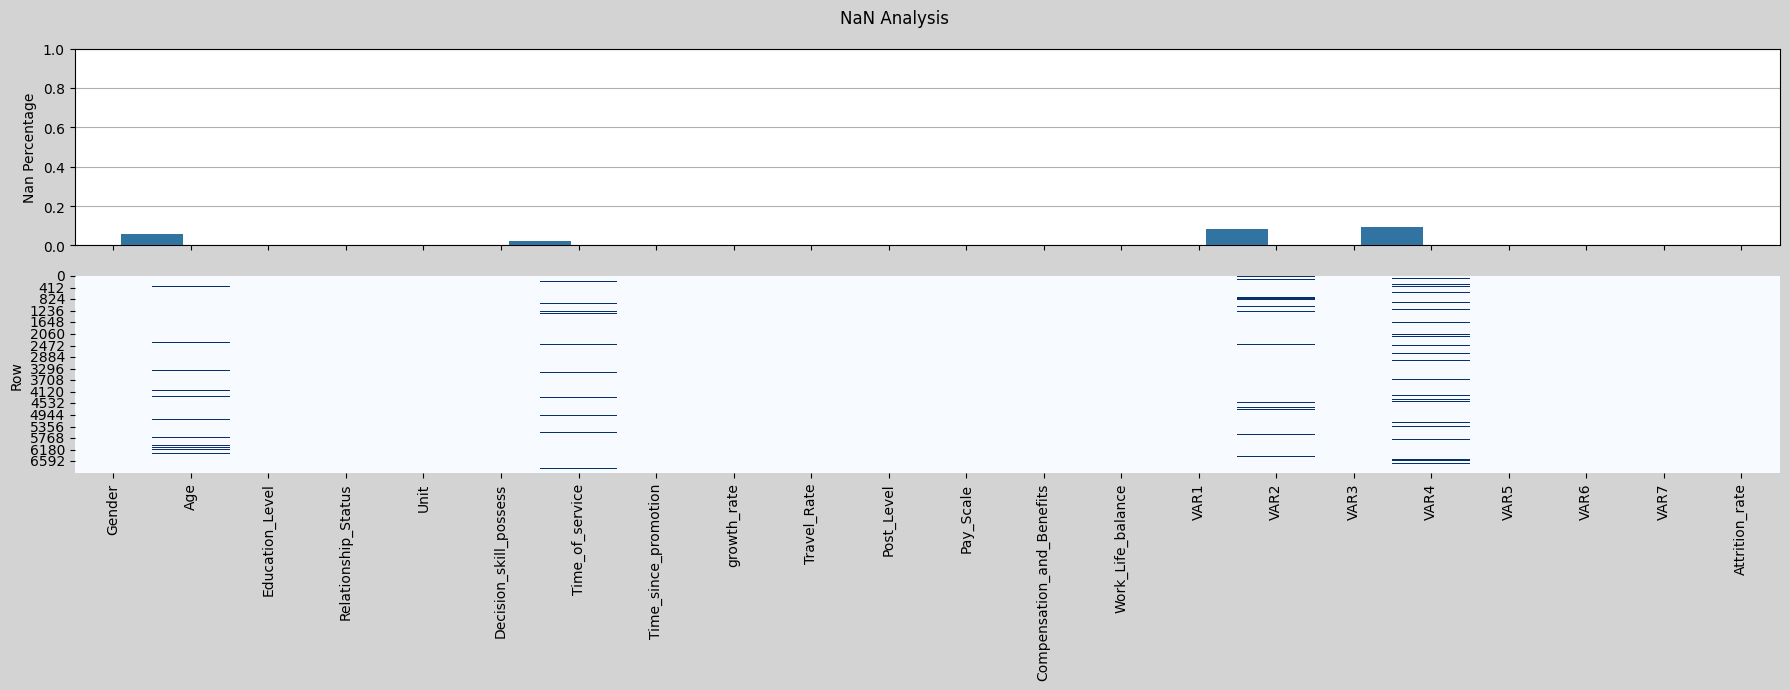

In [4]:
fig, axs = plt.subplots(2,1, figsize=(18,7), facecolor='lightgray', sharex=True)
plt.suptitle('NaN Analysis')

ax1 = plt.subplot(2,1,1)
sns.barplot(x=df_train.columns, y=(df_train.isna().sum()/df_train.shape[0]).values, ax=ax1)
ax1.set_ylim([0,1])
ax1.grid(axis='y')
ax1.set_ylabel('Nan Percentage')

ax2 = plt.subplot(2,1,2)
sns.heatmap(df_train.isnull(), cbar=False,cmap="Blues", ax=ax2);
ax2.set_ylabel('Row')
plt.tight_layout()

#### Removing nan values

In [5]:
# Columns
nan_trhld = .05
cols2drop = df_train.columns[df_train.isna().sum()/df_train.shape[0]>=nan_trhld]
df_train.drop(cols2drop, axis=1, inplace=True)

# Rows
df_train.dropna(inplace=True)
df_train.reset_index(inplace = True, drop = True)

### Analysis of Numerical Variables

#### Summary

In [6]:
# Numerical Columns
numcols = df_train._get_numeric_data().columns
uniques = [df_train[col].unique().shape[0] for col in df_train[numcols].columns]
navals = [df_train[col].unique().shape[0] for col in df_train[numcols].columns]
highcorr = df_train[numcols].columns[((np.abs(df_train[numcols].corr())>=.7).sum()>1).tolist()]
df_summary = df_train[numcols].describe().transpose()
df_summary['uniques'] = uniques
df_summary['nan_vals(%)'] =np.round((100*df_train[numcols].isna().sum()/df_train.shape[0]).tolist(),2)
df_summary.loc[:, 'high_corr(>=.7)'] = 0
df_summary.loc[highcorr, 'high_corr(>=.7)'] = 1
display(df_summary)

,count,mean,std,min,25%,50%,75%,max,uniques,nan_vals(%),high_corr(>=.7)
Education_Level,6838.0,3.187920,1.064095,1.0000,3.000000,3.0000,4.000000,5.0000,5,0.0,0
Time_of_service,6838.0,13.385054,10.366765,0.0000,5.000000,10.0000,21.000000,43.0000,44,0.0,0
Time_since_promotion,6838.0,2.365750,1.150021,0.0000,1.000000,2.0000,3.000000,4.0000,5,0.0,0
growth_rate,6838.0,47.051623,15.767261,20.0000,33.000000,47.0000,61.000000,74.0000,55,0.0,0
Travel_Rate,6838.0,0.816759,0.647832,0.0000,0.000000,1.0000,1.000000,2.0000,3,0.0,0
Post_Level,6838.0,2.798333,1.163213,1.0000,2.000000,3.0000,3.000000,5.0000,5,0.0,0
Pay_Scale,6838.0,6.006581,2.052717,1.0000,5.000000,6.0000,8.000000,10.0000,10,0.0,0
Work_Life_balance,6838.0,2.387394,1.122248,1.0000,1.000000,2.0000,3.000000,5.0000,5,0.0,0
VAR1,6838.0,3.099152,0.837959,1.0000,3.000000,3.0000,3.750000,5.0000,5,0.0,0
VAR3,6838.0,-0.014388,0.988707,-2.7762,-0.453700,-0.4537,0.707500,1.8688,5,0.0,0


#### Explring High Correlated Features

In [7]:
display(df_train[df_summary[df_summary['high_corr(>=.7)']==1].index.tolist()+['Attrition_rate']].corr())

,Attrition_rate
Attrition_rate,1.0


- ***Dropping the highly correlated feature:***

In [8]:
#df_train.drop('Age', axis=1, inplace=True)
#df_summary.drop('Age', inplace=True)

#### Creating a Target Variable, a class that is used to understand the meaning of the Attrition rate variable

An additional feature is created to determine possible classes related to the provided attrition levels, as explained in more detail in the following subsection.

In [9]:
idxs1 = df_train[df_train.Attrition_rate<=.1].index
idxs2 = df_train[(df_train.Attrition_rate>.1) & (df_train.Attrition_rate<=.2)].index
idxs3 = df_train[(df_train.Attrition_rate>.2) & (df_train.Attrition_rate<=1)].index
df_train.loc[:, 'Target'] = 0
for i, idxs in zip(['Low', 'Normal', 'High'], [idxs1, idxs2, idxs3]):
    df_train.loc[idxs, 'Target'] = i

C:\Users\yolad\AppData\Local\Temp\ipykernel_13856\3153945358.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Low' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[idxs, 'Target'] = i


#### Outliers within the Feature of Interest

The map of attrition rates to nominal variables is based on definitions found with respect to the mentioned variable, where attrition rates up to 10% are related to healthy companies, while attrition levels above 20% can be considered indicators that need to be analyzed. Lastly, a middle range was considered to explore the effects of the analyzed attrition rate levels, since, as can be observed in the next figure, it is difficult to find any underlying patterns within the provided values. Its uniform distribution will be a challenge to discover ways of grouping.

In addition, since values close to 1 mean that all employees in a company were replaced, which can be considered a situation with low probability of happening, these can be considered outliers. This assumption is also supported by the interquartile range, as presented next:

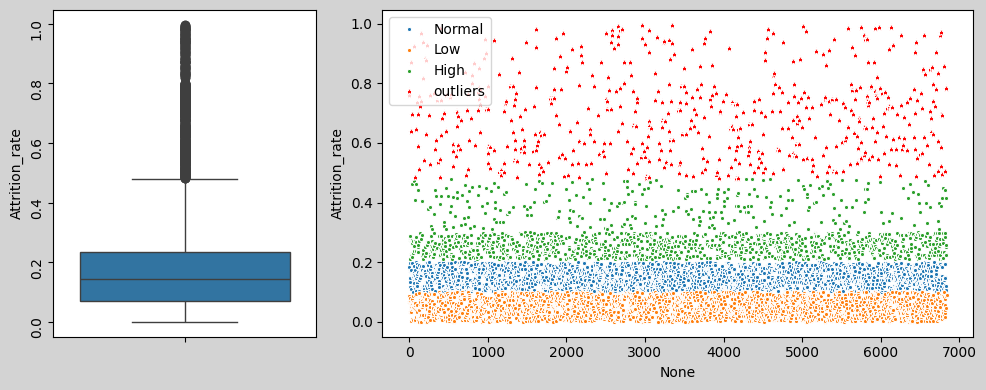

In [10]:
fig = plt.figure(figsize=(10,4), facecolor='lightgray')
fig.subplots_adjust(left=0.2,wspace = 0.1)
ax1 = plt.subplot2grid((1,3),(0,0)) 
sns.boxplot(data=df_train['Attrition_rate'], ax=ax1)
ax1.tick_params(labelrotation=90)

col = 'Attrition_rate'
Q1 = np.percentile(df_train[col], 25, method='midpoint')
Q3 = np.percentile(df_train[col], 75, method='midpoint')
IQR = Q3 - Q1
up_fence = Q3 + 1.5*IQR
low_fence = Q1 - 1.5*IQR
idxs_outliers = df_train[~((df_train[col]>=low_fence) & (df_train[col]<=up_fence))].index

ax2 = plt.subplot2grid((1,3),(0,1),colspan=2) 
sns.lineplot(data= df_train, x=df_train.index, y=df_train.Attrition_rate, linestyle='', marker='.', hue='Target')
sns.lineplot(data= df_train.loc[idxs_outliers], x=df_train.loc[idxs_outliers].index, y='Attrition_rate', linestyle='', marker='*', color='r', label='outliers')
plt.tight_layout()

- ***Removing Attrition_rate Outliers:***

The options of removing or keeping the outliers are tested in this notebook. As presented previously, data related to the identified outliers is uncommon; nonetheless, since the data is too dense and probably related to some degree with the rest of the features, reducing the variability of the data can increase the difficulty of finding clusters to group the data.

In [11]:
#df_train.drop(idxs_outliers, inplace=True)
#df_train.reset_index(inplace = True, drop = True)

#### Numerical features Distributions and Relationships

A negatively correlation, small, can be seeing between the Time of Service variable and the attrition rates provided. Nonetheless, it is small and their effect finding clusters needs to be analyzed. 

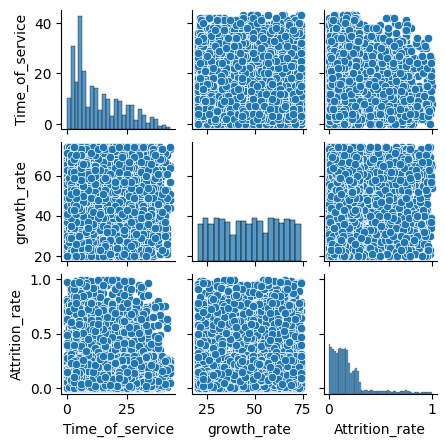

In [12]:
sns.pairplot(df_train[df_summary[df_summary.uniques>10].index], height=1.5, dropna=True);

#### Transforming Features to have the same magnitude effect on the Feature of Interest

A transformer is used to adjust the magnitude of numerical features to avoid biases toward variables with higher magnitudes.

In [13]:
# Reducing the skenesss of the Variable of Interest
df_train.loc[:, 'Attrition_rate_log'] = np.log10(df_train.Attrition_rate.replace({0: .0001}))

#cols = ['Attrition_rate']
cols2trans = df_summary.index[(df_summary['max'] - df_summary['min'])>=1].tolist() #+ ['Attrition_rate']
Transformer = MinMaxScaler()

#Transformer = StandardScaler()
Transformer.fit(df_train[cols2trans])
df_train.loc[:, cols2trans] = Transformer.transform(df_train[cols2trans])

- ***Attrition_rate Distribution***

Additionally, a logarithmic transformation is also tested to determine if an increase in relationships between the attrition variable and the rest of the features is possible. This involves reducing the skewness of  attrition rate distribution by normalizing it.

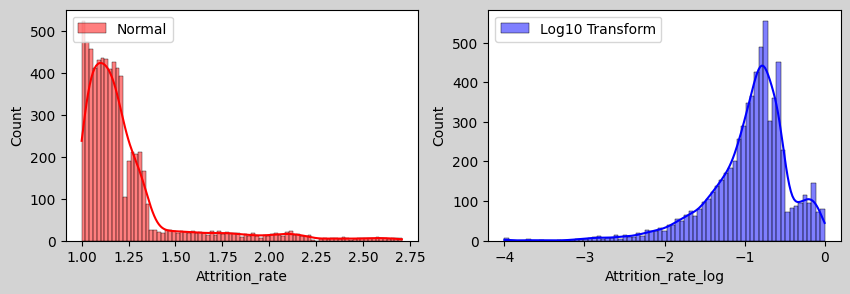

In [14]:
fig, axs = plt.subplots(1,2, figsize=(10,3), facecolor='lightgray')

#sns.histplot(data=datf, x="sepal_length", color="orange", alpha = 1.0, kde = True)
ax1 = plt.subplot(1,2,1)
sns.histplot(np.exp(df_train.Attrition_rate), color='r', fill=True, label='Normal', kde = True, ax=ax1)
ax1.legend(loc='upper left')

ax2 = plt.subplot(1,2,2)
sns.histplot(df_train.Attrition_rate_log, color='b', fill=True, label='Log10 Transform', kde = True, ax=ax2)
ax2.legend(loc='upper left')

### Analysis of Categorical Variables

#### Summary

The characteristics of the categorical variables are presented in the next figure, where their composition with respect to the different values the features can take is shown.

Text(0.5, 1.0, 'Summary of Categorical Variables - Composition')

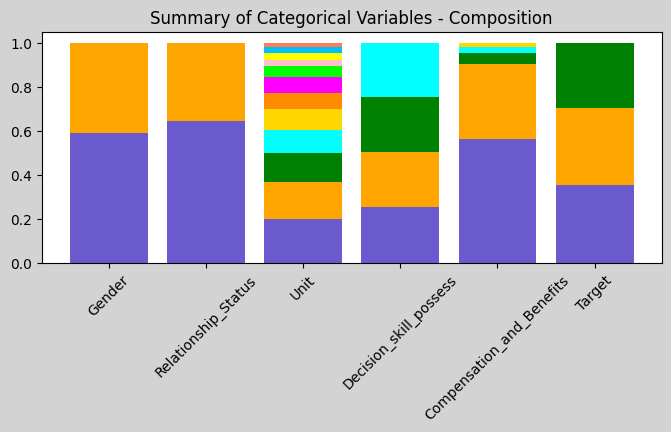

In [15]:
fig = plt.figure(figsize=(8,3), facecolor='lightgray')
colors = ['slateblue', 'orange', 'green', 'cyan', 'gold', 'darkorange', 'magenta', 'lime', 'pink', 'yellow', 'deepskyblue', 'coral']
idx = 0
for col in df_train.dtypes[df_train.dtypes == type(str)].index.tolist():
    suma = 0
    for i, val in enumerate((df_train[col].value_counts()/df_train.shape[0]).tolist()):
        plt.bar(col, val, bottom=suma, color=colors[i]);
        suma += val
    idx +=1
plt.xticks(rotation=45);
plt.title('Summary of Categorical Variables - Composition')

#### Defining the Categorical Features

In [16]:
catcols = df_train.dtypes[df_train.dtypes == type(str)].index.tolist()
bolcols = [col for col in catcols if df_train[col].unique().shape[0]==2]
catcols = [col for col in catcols if col not in (bolcols + ['Target'])]

#### Processing Boolean Features

In [17]:
for col in bolcols:
    New_name = (col+'_'+df_train[col].unique()[0])
    df_train[col].replace(df_train[col].unique().tolist(),[0, 1], inplace=True)
    df_train.rename(columns={col:New_name}, inplace=True)

#### Grouping Units with similar activities to reduce classes with low frequencies

In [18]:
Operations = ['Operations','Production', 'Quality', 'Operarions']
Finance = ['Accounting and Finance', 'Sales', 'Purchasing']
Human_Resources = ['Human Resource Management', 'Marketing', 'Security']

# Combining Similar Departments 
for dep in [Operations, Finance, Human_Resources]:
    idxs = df_train.index[df_train[catcols[0]].isin(dep)]
    df_train.loc[idxs, catcols[0]] = dep[0]

display(pd.DataFrame(df_train['Unit'].value_counts()))

,count
Unit,
Accounting and Finance,1904
IT,1366
Logistics,1134
Operations,1090
Human Resource Management,679
R&D,665


#### Encoding Categorical Features using One-Hot Encoders

In [19]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df_train[catcols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(catcols))
df_encoded = pd.concat([df_train, one_hot_df], axis=1)
df_encoded.drop(catcols, axis=1, inplace=True)
display(df_encoded.head())

,Gender_F,Education_Level,Relationship_Status_Married,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,...,Unit_R&D,Decision_skill_possess_Analytical,Decision_skill_possess_Behavioral,Decision_skill_possess_Conceptual,Decision_skill_possess_Directive,Compensation_and_Benefits_type0,Compensation_and_Benefits_type1,Compensation_and_Benefits_type2,Compensation_and_Benefits_type3,Compensation_and_Benefits_type4
0,0,0.75,0,0.093023,1.00,0.240741,0.5,0.00,0.666667,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,0.50,1,0.116279,1.00,0.296296,0.0,0.50,0.555556,0.75,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,0.50,0,0.627907,0.75,0.574074,0.0,0.25,0.777778,0.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,0.50,1,0.093023,0.75,0.666667,0.5,0.50,0.777778,0.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0.00,0,0.116279,1.00,0.777778,0.5,0.50,0.111111,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Linear Correlation Analysis

#### Correlation Matrix

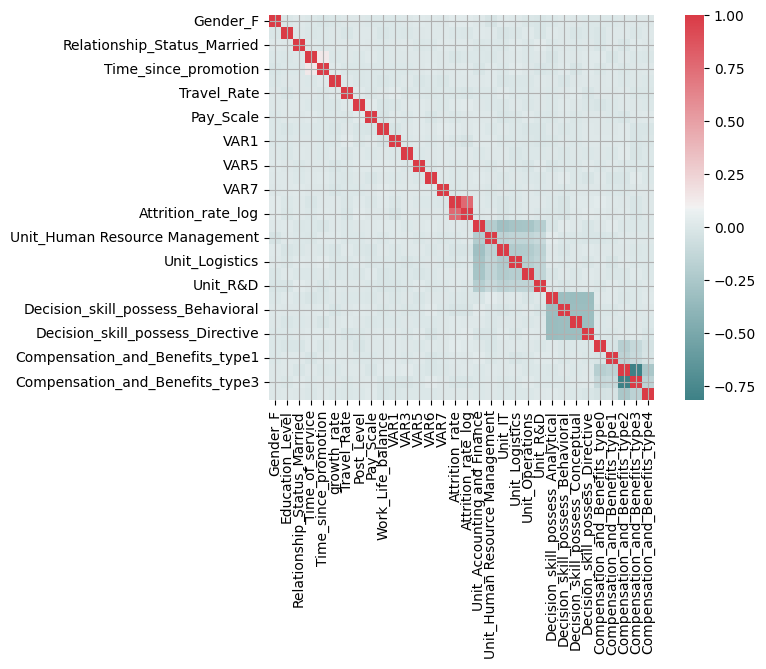

In [20]:
cols4corr = [col for col in df_encoded.columns if col != 'Target']
corr = df_encoded[cols4corr].corr()

#Looking for highly correlated data
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool_), cmap=sns.diverging_palette(200, 10, as_cmap=True),
            square=True, ax=ax)
plt.grid()

#### Features Correlation with the Variable of Interest

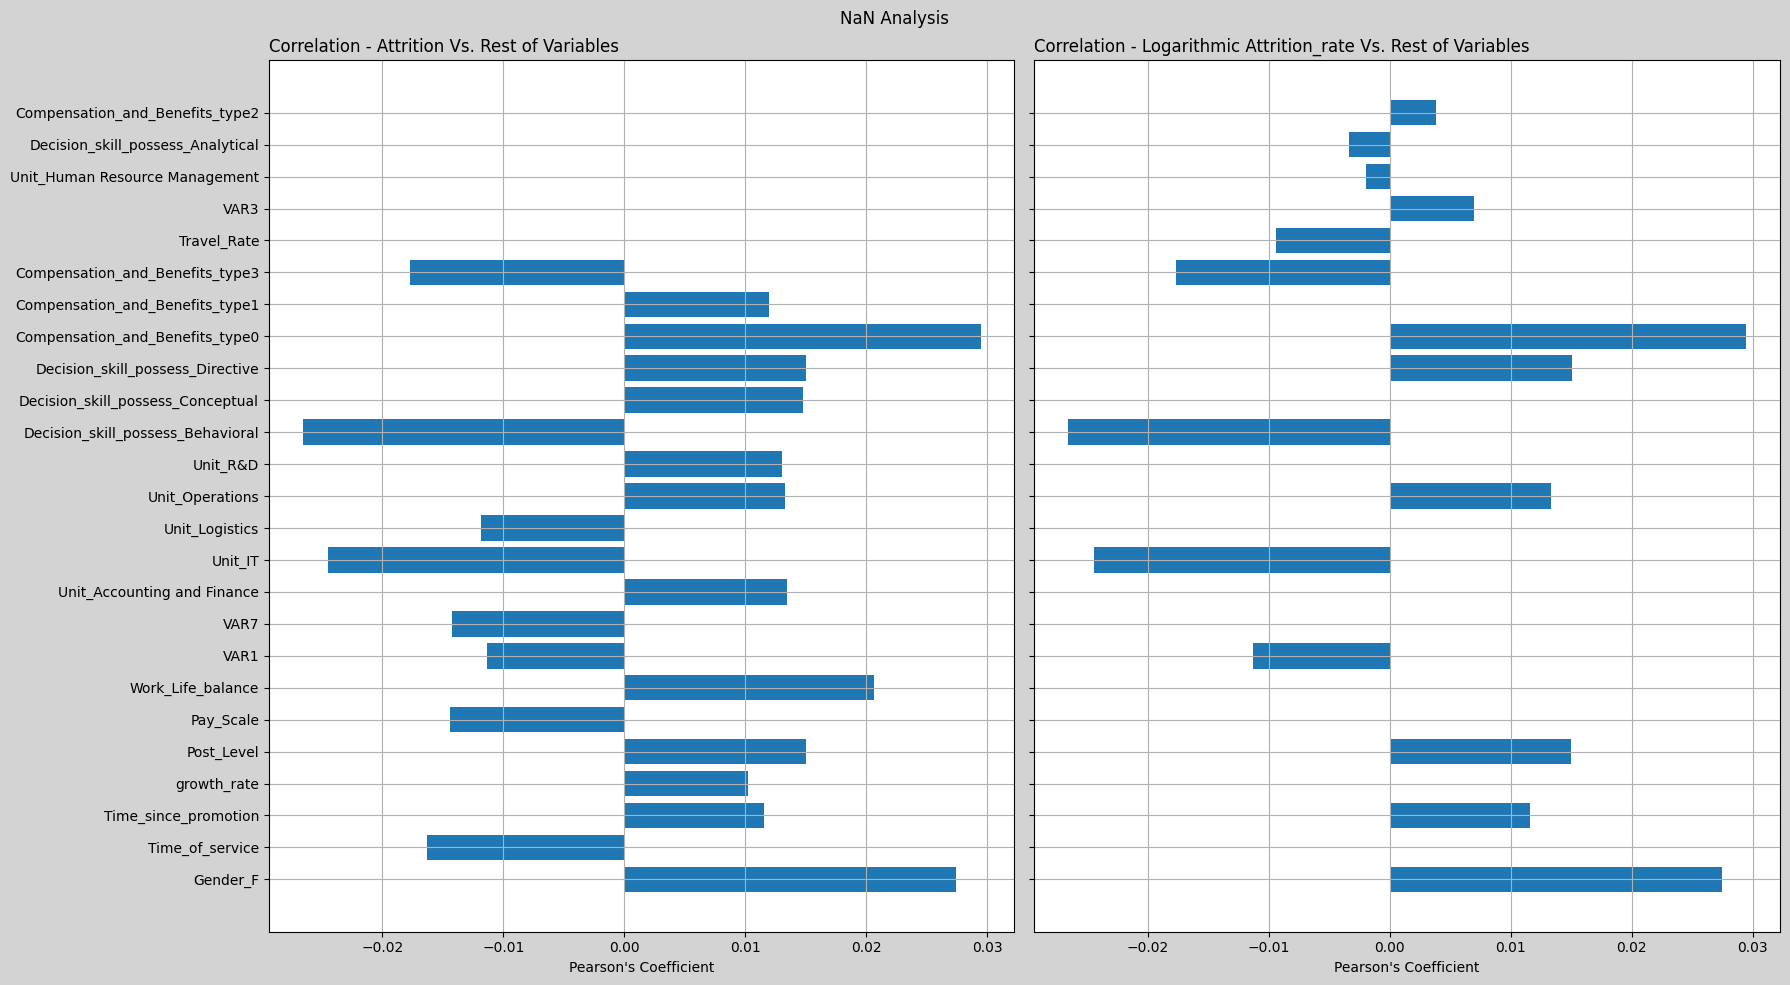

In [21]:
# Only features correlated above a Pearson coefficient threshold level with respect to the attrition rate are kept.
thrsld = .01
corr = df_encoded[cols4corr].corr().drop(['Attrition_rate', 'Attrition_rate_log'], axis=0)

fig, axs = plt.subplots(1,2, figsize=(18,10), facecolor='lightgray', sharey=True)
plt.suptitle('NaN Analysis')

ax1 = plt.subplot(1,2,1)
idxs_nor = corr.index[(np.abs(corr[['Attrition_rate']])>=thrsld).values.transpose()[0]]
ax1.barh(corr.loc[idxs_nor, 'Attrition_rate'].index, corr.loc[idxs_nor, 'Attrition_rate'])
# Add Plot Title
ax1.set_title('Correlation - Attrition Vs. Rest of Variables',
             loc ='left', )
ax1.set_xlabel("Pearson's Coefficient")
ax1.grid()

ax2 = plt.subplot(1,2,2)
idxs_log = corr.index[(np.abs(corr[['Attrition_rate_log']])>=thrsld).values.transpose()[0]]
ax2.barh(corr.loc[idxs_log, 'Attrition_rate_log'].index, corr.loc[idxs_log, 'Attrition_rate'])
# Add Plot Title
ax2.set_title('Correlation - Logarithmic Attrition_rate Vs. Rest of Variables',
             loc ='left', )
ax2.set_xlabel("Pearson's Coefficient")
ax2.grid()

plt.tight_layout()

In [22]:
# Creating a copy of the orinal dataframe for the final analysis
df_encoded_bu = df_encoded.copy()

### Clustering Features to Characterize the Attrition_rate

#### **Preparing the Data for the Clustering**

In [23]:
#df_encoded = df_encoded[idxs_log.tolist() + ['Attrition_rate_log', 'Target']]
#cols = df_encoded.columns.drop(['Attrition_rate_log', 'Target']).tolist()

df_encoded = df_encoded[idxs_nor.tolist() + ['Attrition_rate', 'Target']]
cols = df_encoded.columns.drop(['Attrition_rate', 'Target']).tolist()

#### **PCA Analysis**

- ***Generating the PCA model***

In [24]:
# Applying PCA to the data
columns = df_encoded.columns[:-2]
pca = PCA()
pca.fit(df_encoded[columns])

PCA()

- ***Gathering of the initial PCA components***

In [25]:
dfPCA = pca.transform(df_encoded[columns])

- ***Cumulative analysis for the PCA components' variances***

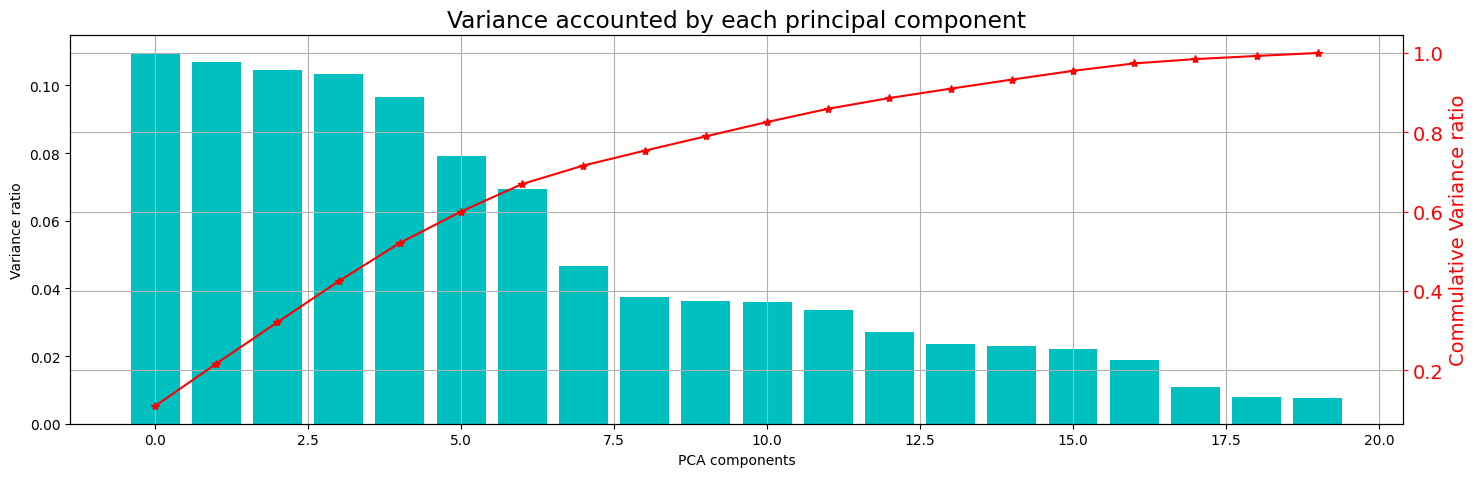

In [26]:
# Investigate the variance accounted by each principal component.
VarRat = pca.explained_variance_ratio_

Suma = 0
VarRatAcum = []

for var in pca.explained_variance_ratio_:
    Suma+=var
    VarRatAcum.append(Suma)

PCAvariance(VarRat, VarRatAcum)

- ***Generating the PCA components for the clustering technique***

As shown in the previous figure, the first 10 principal components capture at least 80% of the total variance in the data. This suggests that these components effectively summarize the key information, facilitating dimensionality reduction.

In [27]:
# Selecting the number of PCA components responsible for at least 80% of the total data variation
pca = PCA(n_components=10)
pca.fit(df_encoded[columns])
dfPCA = pca.transform(df_encoded[columns])

- ***Visualizing the composition of a obtained PCA component***

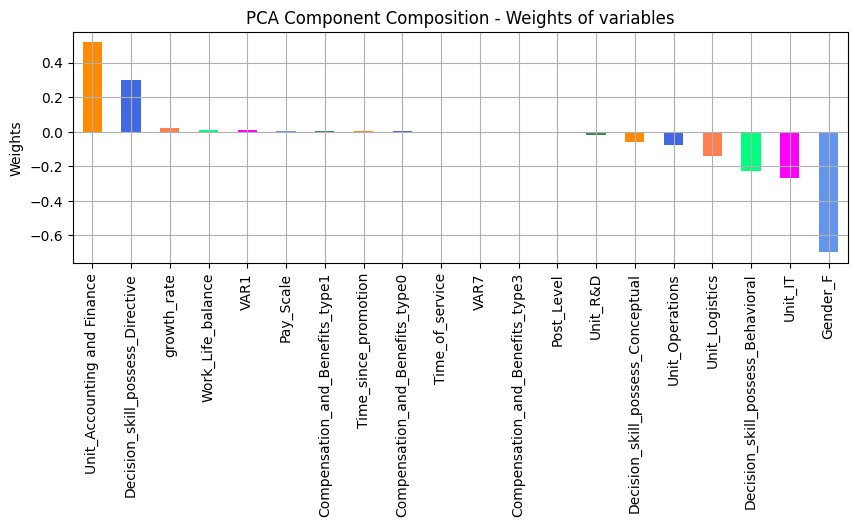

In [28]:
PCAcompWeights(pca, df_encoded[columns], 3, plot=True, figsize=(10,3))

#### **Clustering**

**Determining the number of centroids to cluster the Data**

- *Using the Elbow Method:*

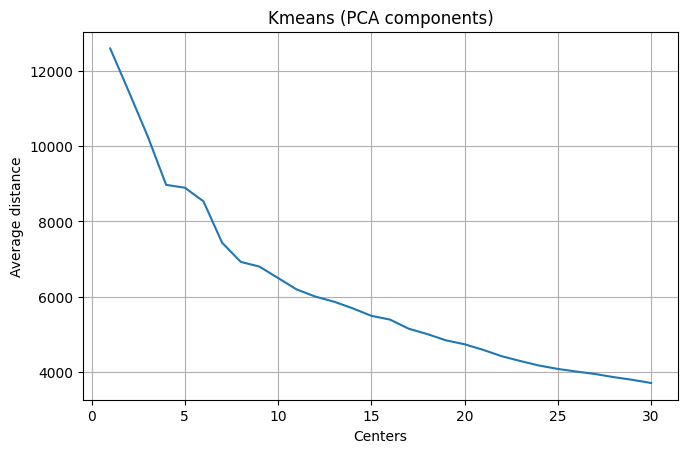

In [29]:
# Number of centroids to cluster the data
n_scor = [30]
# Applying the Elbow method
PCATest(dfPCA, n_scor, dfPCA.shape[0], layout=(1,1), Figsize=(7,4))

- *Using the Silhouette Coefficients*

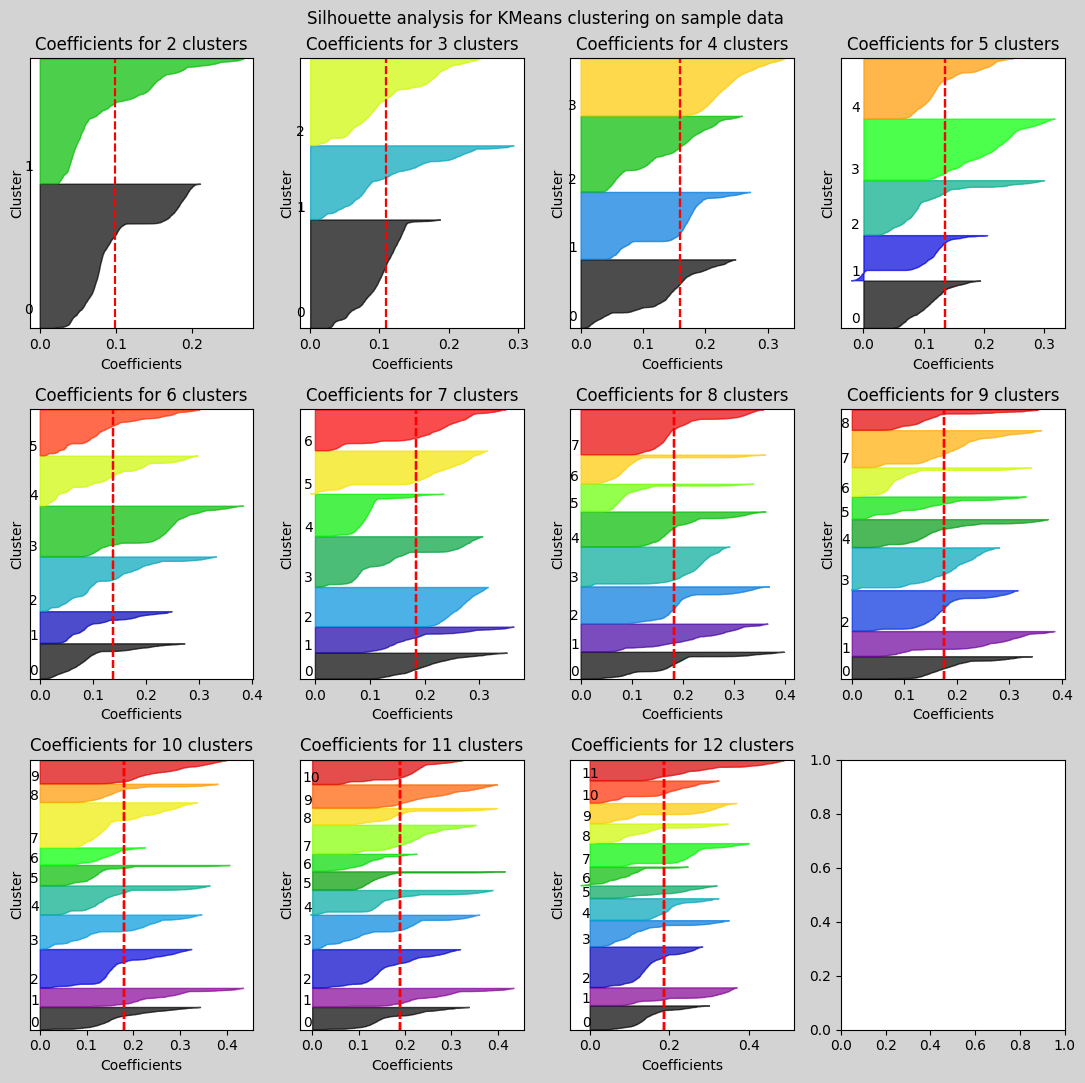

In [30]:
#Plotting the Silhouette Coeficients
Plotting_SilhouetteCoef_TLG(dfPCA, 13)

**Analyzing the resulting data segmentation**

Based on the results obtained from applying the Elbow method and the Silhouette coefficients, 8 centroids are used to cluster the data

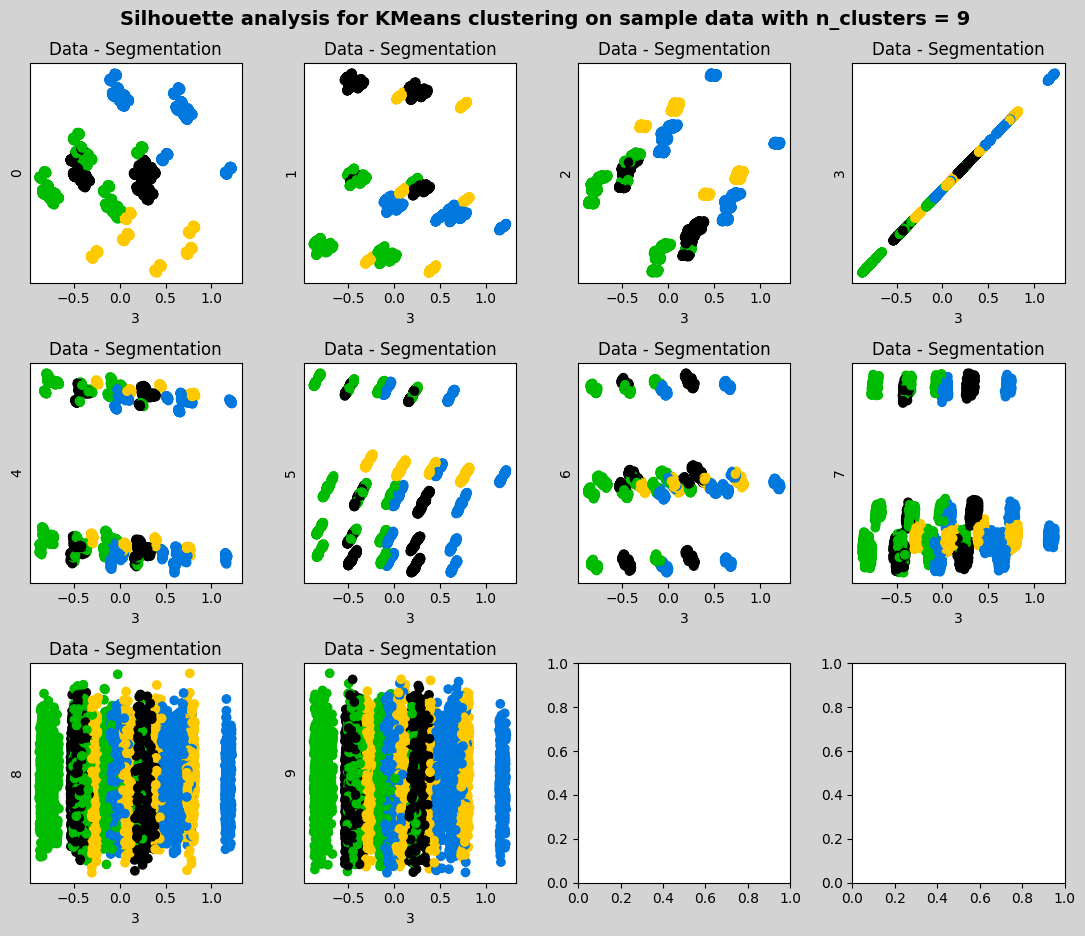

In [31]:
# Number of Clusters
nc = 4
# Clustering the Data
kmeans = KMeans(nc, random_state=0, n_init='auto')
model = kmeans.fit(dfPCA)
PredAttrition = model.predict(dfPCA)
df_encoded['Pred_Attrition'] = PredAttrition

Plotting_Predictions_DfComponents(pd.DataFrame(dfPCA), PredAttrition, nc, 3)

### Conclusions

#### Returning data to their orignal range of values

In [32]:
df_analysis = df_encoded_bu.copy()
df_analysis['Pred_Attrition'] = PredAttrition
df_analysis.loc[:, cols2trans] = Transformer.inverse_transform(df_analysis[cols2trans])

#### Plotting Obtained Insights

- ***Relationshipts with ordinal Variables***

<Axes: >

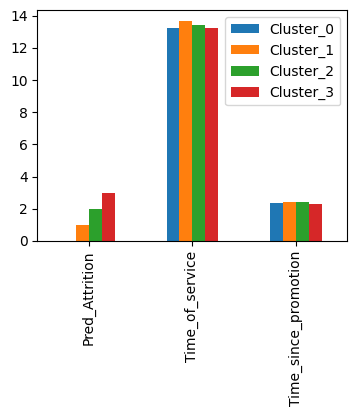

In [33]:
df_tmp = (df_analysis.groupby('Pred_Attrition')[['Time_of_service', 'Time_since_promotion']].mean()).reset_index().transpose()
df_tmp.columns = ['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']
fig, ax = plt.subplots(figsize=(4, 3))
df_tmp.iloc[:].plot.bar(ax=ax)

- ***Relationshipts with Nominal Variables (a)***

<Axes: >

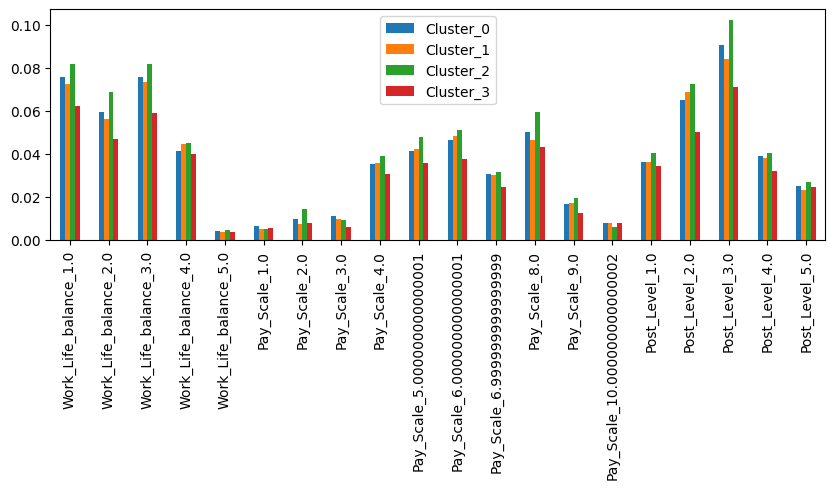

In [34]:
col = ['Work_Life_balance', 'Pay_Scale', 'Post_Level']
encoder_tmp = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder_tmp.fit_transform(df_analysis[col])
onehotdf = pd.DataFrame(one_hot_encoded, columns=encoder_tmp.get_feature_names_out(col))
df_tmp = pd.concat([df_analysis[['Pred_Attrition']], onehotdf], axis=1)
df_tmp = (df_tmp.groupby('Pred_Attrition').sum()/df_analysis.shape[0]).reset_index().transpose()
df_tmp.columns = ['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']
fig, ax = plt.subplots(figsize=(10, 3))
df_tmp.iloc[1:].plot.bar(ax=ax)


- ***Relationshipts with Nominal Variables (b)***

<Axes: >

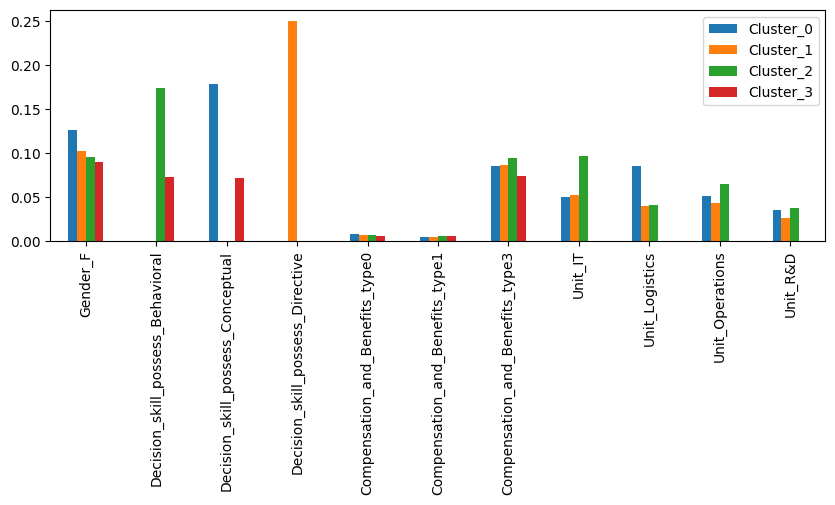

In [35]:
df_tmp = df_analysis.groupby('Pred_Attrition')[['Gender_F', 'Decision_skill_possess_Behavioral', 'Decision_skill_possess_Conceptual',
                                       'Decision_skill_possess_Directive', 'Compensation_and_Benefits_type0',
                                       'Compensation_and_Benefits_type1', 'Compensation_and_Benefits_type3',
                                       'Unit_IT', 'Unit_Logistics', 'Unit_Operations', 'Unit_R&D']].sum().transpose()/df_analysis.shape[0]
df_tmp.columns = ['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']
fig, ax = plt.subplots(figsize=(10, 3))
df_tmp.plot.bar(ax=ax)

#### Conclusion

It can be concluded that employee attrition levels can be linked to the features available in the provided dataset, with different features influencing attrition to varying degrees. One of the main challenges in this analysis is that many of the provided features affect attrition levels similarly, making it difficult to identify the key factors driving attrition.

The results were obtained by scaling the data to mitigate biases associated with higher magnitudes, as well as by removing null values and features with low correlation to attrition levels. Additionally, PCA was employed to enhance the characterization of the features, utilizing principal components that explain at least 80% of the total variance in the data. This approach filters out components that contribute minimally, thereby reducing the impact of features that are weakly correlated with attrition levels.

Moreover, kmeans was used to cluster the data, expecting to find groups of employees with similar attrition levels within the mentioned clusters. Unfortunately, while data segmentation was possible and visualizations demonstrated that the clusters separate employees with different characteristics, identifying features related to attrition levels remains challenging,  as can be seeing in the previous presented Figures. 

Nonetheless, it can be observed that the Decision_skill_possess variable behaves differently based on employee attrition levels. However, this relationship alone cannot determine which employees belong to which clusters, as this variable accounts for only about 20% of the attrition levels. The remaining variables are responsible for the other 80% of the sources of employee attrition. Therefore, the extent to which variables unrelated to decision skills contribute to attrition levels remains unclear

## FIN